In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv').values.reshape(-1,1,28,28)

labels = train_data['label'].values
data = train_data.drop('label', axis=1).values.reshape(-1,1,28,28)

data.shape, test_data.shape

((42000, 1, 28, 28), (28000, 1, 28, 28))

In [3]:
x = torch.FloatTensor(data) #.cuda()
y = torch.LongTensor(labels.tolist()) #.cuda()

In [4]:
epochs = 5
batch_size = 50

In [5]:
class Network(nn.Module): 
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


In [6]:
net = Network() #.cuda()
optimizer = optim.Adam(net.parameters(), lr=0.001) 
loss_func = nn.CrossEntropyLoss()

In [7]:
loss_log = []

for e in range(epochs):
    for i in range(0, x.shape[0], batch_size):
        x_mini = x[i:i + batch_size] 
        y_mini = y[i:i + batch_size]
        
        optimizer.zero_grad()
        net_out = net(x_mini)
        
        loss = loss_func(net_out, y_mini)
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
            loss_log.append(loss.item())
        
    print('Epoch: {} - Loss: {:.6f}'.format(e + 1, loss.item()))

Epoch: 1 - Loss: 0.507113
Epoch: 2 - Loss: 0.245935
Epoch: 3 - Loss: 0.111661
Epoch: 4 - Loss: 0.075689
Epoch: 5 - Loss: 0.083451


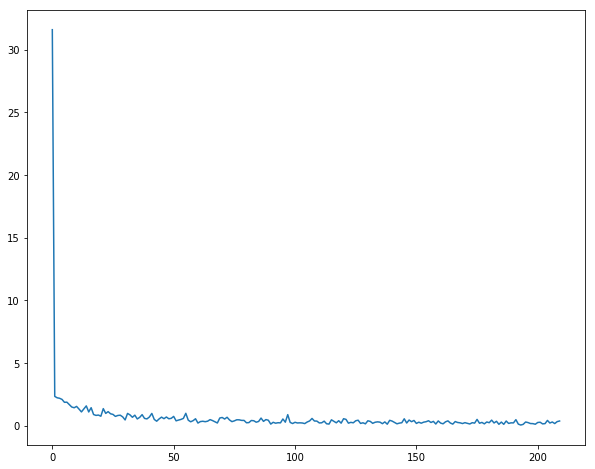

In [8]:
plt.figure(figsize=(10,8))
plt.plot(loss_log)

In [10]:
test = torch.FloatTensor(test_data)
test_var = test

net_out = net(test_var)

In [11]:
output = (torch.max(net_out.data, 1)[1]).numpy()

np.savetxt("submission.csv", np.dstack((np.arange(1, output.size+1),output))[0],"%d,%d", header="ImageId,Label", comments='')